# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# Import Dataset

In [ ]:
working_dir = './' # WORKING DIRECTORY
dataset_dir = working_dir + '/Dataset'

train_dir = dataset_dir + '/train'
val_dir = dataset_dir + '/validation'
test_dir = dataset_dir + '/test'


## Image Preparation

### Create Generator

In [ ]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    rescale=1/255.,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    brightness_range=[0.3,0.7]
)
val_datagen = ImageDataGenerator(
    rescale=1/255.,
)
test_datagen = ImageDataGenerator(
    rescale=1/255.,
)

### Assign Generator to the Image Dataset

NB:
1. `shuffle` pada `flow_from_directory`:
  - Di-set `True` pada data latih agar model tidak terpaku pada urutan.
  - Di-set `False` pada data validasi dan uji agar sesuai dengan daftar label/class-nya saat validasi dan testing.

2. `IMAGE_SIZE` = ukuran image yang akan digunakan oleh model. **Mobilenet & MobilenetV2 hanya menerima citra dengan resolusi tertentu, salah satunya $224 \times 224$**


In [ ]:
IMG_SIZE = (224, 224)
train_gen = train_datagen.flow_from_directory(train_dir,
                                              shuffle=True,
                                              target_size=IMG_SIZE)

val_gen = val_datagen.flow_from_directory(val_dir, shuffle=False,
                                            target_size=IMG_SIZE)

test_gen = test_datagen.flow_from_directory(test_dir, shuffle=False,
                                            target_size=IMG_SIZE)

Found 320 images belonging to 10 classes.
Found 40 images belonging to 10 classes.
Found 40 images belonging to 10 classes.


# Model Training

## Preparing the Mobilenet V2

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


### Freeze the Convolution Layers

Since we don't need to retrain the Mobilenet in this study, we put these layers in whitelist for the training.

In [ ]:
base_model.trainable = False

## Build the whole model



In [ ]:
model = tf.keras.Sequential([
                             base_model, # This is the MobilenetV2
                             tf.keras.layers.Flatten(), # Flatten the multidimension features into 1D
                             
                             # The Fully Connected (Hidden) Layer, you may customize the number, I used 64 as it performs good enough already
                             # This can contain more layers if the performance isn't good enough
                             tf.keras.layers.Dense(64, activation='relu'),

                             # The number of units here is for the number of classes in the dataset
                             tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4014144   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 6,272,778
Trainable params: 4,014,794
Non-trainable params: 2,257,984
_________________________________________________________________


### Early Stopping Strategy

In [ ]:
callback_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

## Train the model

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=100, callbacks=[callback_acc])

Epoch 1/100
10/10 [==============================] - 6s 619ms/step - loss: 10.1243 - accuracy: 0.1781 - val_loss: 1.7220 - val_accuracy: 0.4500
Epoch 2/100
10/10 [==============================] - 5s 494ms/step - loss: 2.0260 - accuracy: 0.2562 - val_loss: 1.5989 - val_accuracy: 0.3750
Epoch 3/100
10/10 [==============================] - 5s 489ms/step - loss: 1.8907 - accuracy: 0.3063 - val_loss: 1.5319 - val_accuracy: 0.4500
Epoch 4/100
10/10 [==============================] - 5s 485ms/step - loss: 1.6551 - accuracy: 0.4125 - val_loss: 1.5593 - val_accuracy: 0.5750
Epoch 5/100
10/10 [==============================] - 5s 489ms/step - loss: 1.4411 - accuracy: 0.4875 - val_loss: 1.0246 - val_accuracy: 0.6500
Epoch 6/100
10/10 [==============================] - 5s 481ms/step - loss: 1.3594 - accuracy: 0.5219 - val_loss: 1.1180 - val_accuracy: 0.6750
Epoch 7/100
10/10 [==============================] - 5s 488ms/step - loss: 1.3003 - accuracy: 0.5750 - val_loss: 0.6962 - val_accuracy: 0.775

# Model Testing and Evaluation

## Plot the accuracy and the loss during training process

In [ ]:
best_score = max(history.history['val_accuracy'])
print(best_score)

1.0


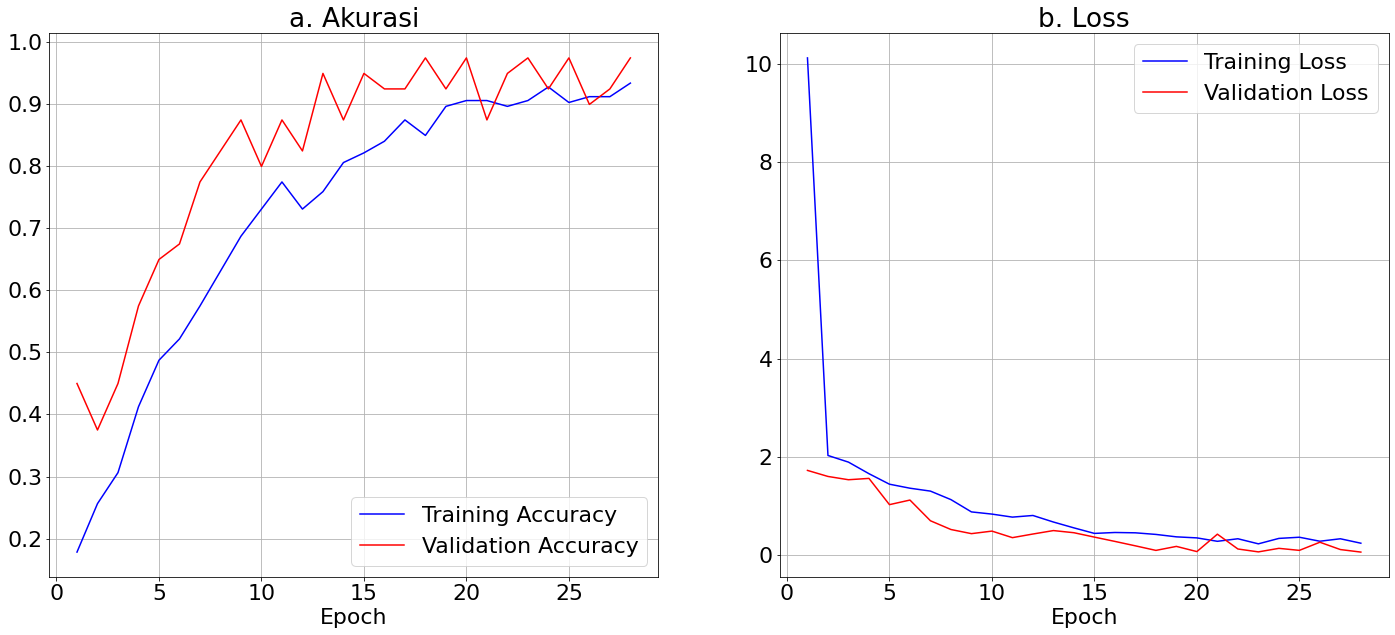

In [ ]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.rcParams.update({'font.size': 22})

    plt.figure(figsize = (24, 10))
    plt.subplot(1,2,1)
    plt.title('a. Akurasi')
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    
    plt.subplot(1,2,2)
    plt.title('b. Loss')
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

plot_results(history)

## Get the Class Labels ready


In [ ]:
class_labels = list(test_gen.class_indices.keys()) 
class_labels

['Bangau leher-hitam',
 'Curik Bali',
 'Ekek Geling',
 'Gelatik Jawa',
 'Kakatua Raja',
 'Luntur harimau',
 'Merak Hijau',
 'Paok Bidadari',
 'Raja udang kalung-biru Jawa',
 'Sikatan besar']

## Produce the Classification Report

If the `shuffle` in [this cell](#scrollTo=i7cJeW9qj5US&line=8&uniqifier=1) is set to `True`, Tensorflow will just shuffle it every runtime. Everytime you run it, it will be shuffled! The worse case is the label and predicted may not match during the recap by `classification_report` or `confusion_matrix`. (Simply say it'll be messed up)

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

predictions = model.predict_generator(test_gen)
print(classification_report(test_gen.classes, np.argmax(predictions, axis=1), target_names=class_labels))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


                             precision    recall  f1-score   support

         Bangau leher-hitam       1.00      1.00      1.00         4
                 Curik Bali       1.00      1.00      1.00         4
                Ekek Geling       1.00      1.00      1.00         4
               Gelatik Jawa       1.00      1.00      1.00         4
               Kakatua Raja       1.00      1.00      1.00         4
             Luntur harimau       1.00      1.00      1.00         4
                Merak Hijau       1.00      1.00      1.00         4
              Paok Bidadari       1.00      1.00      1.00         4
Raja udang kalung-biru Jawa       0.80      1.00      0.89         4
              Sikatan besar       1.00      0.75      0.86         4

                   accuracy                           0.97        40
                  macro avg       0.98      0.97      0.97        40
               weighted avg       0.98      0.97      0.97        40



## Confusion Matrix

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

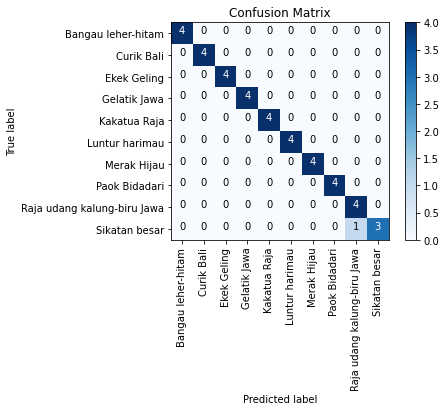

In [ ]:
cm = confusion_matrix(y_true=test_gen.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=class_labels, title='Confusion Matrix')

# Save the Model

In [ ]:
save_dir = working_dir + '/Tensorflow_PY_Model'
model.save(save_dir+'/SavedModel')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/Bird-Identification/Tensorflow_PY_Model/SavedModel/assets


INFO:tensorflow:Assets written to: /content/Bird-Identification/Tensorflow_PY_Model/SavedModel/assets


In [ ]:
model.save(save_dir+'/SavedModel.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Load the Saved Model and Recheck

In [ ]:
model = tf.keras.models.load_model(working_dir + '/SavedModel')

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4014144   
_________________________________________________________________
dense_21 (Dense)             (None, 10)                650       
Total params: 6,272,778
Trainable params: 4,014,794
Non-trainable params: 2,257,984
_________________________________________________________________


# Generate Model Flowchart

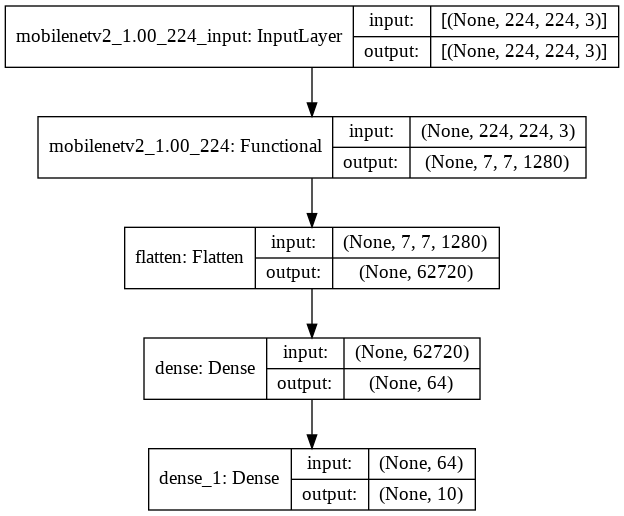

In [ ]:
dot_img_file = working_dir+'model_arch.png'
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 7.4 MB/s 


In [ ]:
model.layers

In [ ]:
import visualkeras

model = tf.keras.models.load_model(path_to_savedmodel)
visualkeras.layered_view(model).show() # display using your system viewer

In [ ]:

visualkeras.layered_view(model, to_file='a.png').show()

# Convert to TensorflowJS

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 64 kB 3.3 MB/s 


In [ ]:
!mv {working_dir} '/content/drive/MyDrive/Skripsi/[NEW TOPIC] Wildlife Identification/Code'

In [ ]:
path_to_h5 = working_dir + '/Tensorflow_PY_Model/SavedModel.h5'
path_to_savedmodel = working_dir + '/Tensorflow_PY_Model/SavedModel'
path_tfjs = working_dir + '/TensorflowJS'

In [ ]:
!tensorflowjs_converter --input_format keras \
                        {path_to_h5} \
                       {path_tfjs}

2021-07-29 08:17:59.873409: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Interactive Prediction

In [ ]:
model = tf.keras.models.load_model(working_dir + '/Tensorflow_PY_Model/SavedModel.h5')

Saving Kakatua raja.jpg to Kakatua raja.jpg


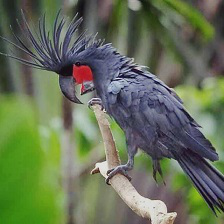

In [ ]:
from google.colab import files
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

uploaded = files.upload()
last_uploaded = list(uploaded.keys())[-1]
im = Image.open(BytesIO(uploaded[last_uploaded]))

im = im.resize(size=(224,224))
display(im)

In [ ]:
img = np.array(im)
img = img / 255.0
prediction1 = model.predict(img[None,:,:])
sorting = (-prediction1).argsort()

# getting the top 2 predictions
sorted_ = sorting[0][:3]

class_labels = ['Bangau leher-hitam',
 'Curik Bali',
 'Ekek Geling',
 'Gelatik Jawa',
 'Kakatua Raja',
 'Luntur harimau',
 'Merak Hijau',
 'Paok Bidadari',
 'Raja udang kalung-biru Jawa',
 'Sikatan besar']

for value in sorted_:
    # you can get your classes from the encoder(your_classes = encoder.classes_) 
    # or from a dictionary that you created before.
    # And then we access them with the predicted index.
    predicted_label = class_labels[value]

    # just some rounding steps
    prob = (prediction1[0][value]) * 100
    prob = "%.2f" % round(prob,2)
    print("I have {}% sure that it belongs to {}.".format(prob, predicted_label))

I have 99.99% sure that it belongs to Kakatua Raja.
I have 0.01% sure that it belongs to Bangau leher-hitam.
I have 0.00% sure that it belongs to Merak Hijau.


In [ ]:
print(prediction1)

[[6.1504150e-05 4.8508531e-11 5.1813848e-15 2.1887154e-12 9.9993849e-01
  8.4171114e-13 1.4638757e-08 3.4268971e-14 7.5719299e-15 1.0649443e-16]]
